<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/Hg_Edgar_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your Excel file
file_path = '/content/drive/My Drive/ColabDataFolders/Hg-EDGAR/Hg_D_m_2000_2022.xlsx'

# Read the Excel file
df = pd.read_excel(file_path, header=0)

# Display the first few rows to confirm it loaded correctly
print(df.head())

# Get basic information about the dataset
print("\nBasic information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:")
print(df.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    IPCC_annex       C_group_IM24_sh Country_code_A3   Name  \
0  Non-Annex_I  Rest Central America             ABW  Aruba   
1  Non-Annex_I  Rest Central America             ABW  Aruba   
2  Non-Annex_I  Rest Central America             ABW  Aruba   
3  Non-Annex_I  Rest Central America             ABW  Aruba   
4  Non-Annex_I  Rest Central America             ABW  Aruba   

  ipcc_code_2006_for_standard_report  \
0                              1.A.2   
1                              1.A.5   
2                              1.A.4   
3                            1.A.1.a   
4                            1.A.1.a   

         ipcc_code_2006_for_standard_report_name fossil_bio Substance  Year  \
0      Manufacturing Industries and Construction        bio      Hg_D  2000   
1                                  Non-Specified        bio      Hg_D  2000   
2             

Dataset overview:
Number of rows: 57189
Number of columns: 21

Column names: ['IPCC_annex', 'C_group_IM24_sh', 'Country_code_A3', 'Name', 'ipcc_code_2006_for_standard_report', 'ipcc_code_2006_for_standard_report_name', 'fossil_bio', 'Substance', 'Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

First few rows:
    IPCC_annex       C_group_IM24_sh Country_code_A3   Name  \
0  Non-Annex_I  Rest Central America             ABW  Aruba   
1  Non-Annex_I  Rest Central America             ABW  Aruba   
2  Non-Annex_I  Rest Central America             ABW  Aruba   
3  Non-Annex_I  Rest Central America             ABW  Aruba   
4  Non-Annex_I  Rest Central America             ABW  Aruba   

  ipcc_code_2006_for_standard_report  \
0                              1.A.2   
1                              1.A.5   
2                              1.A.4   
3                            1.A.1.a   
4                            1.A.1.a   

         ipcc_code_2006_f

<ipython-input-13-d24ce0128d5c>:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_pivot = country_pivot[country_pivot[2000] > 0][country_pivot[2022] > 0]


Saved high impact countries visualization to 'visualizations/high_impact_countries.png'
Saved bar chart to 'visualizations/top20_percent_change.png'
Saved bar chart to 'visualizations/top20_global_fraction.png'


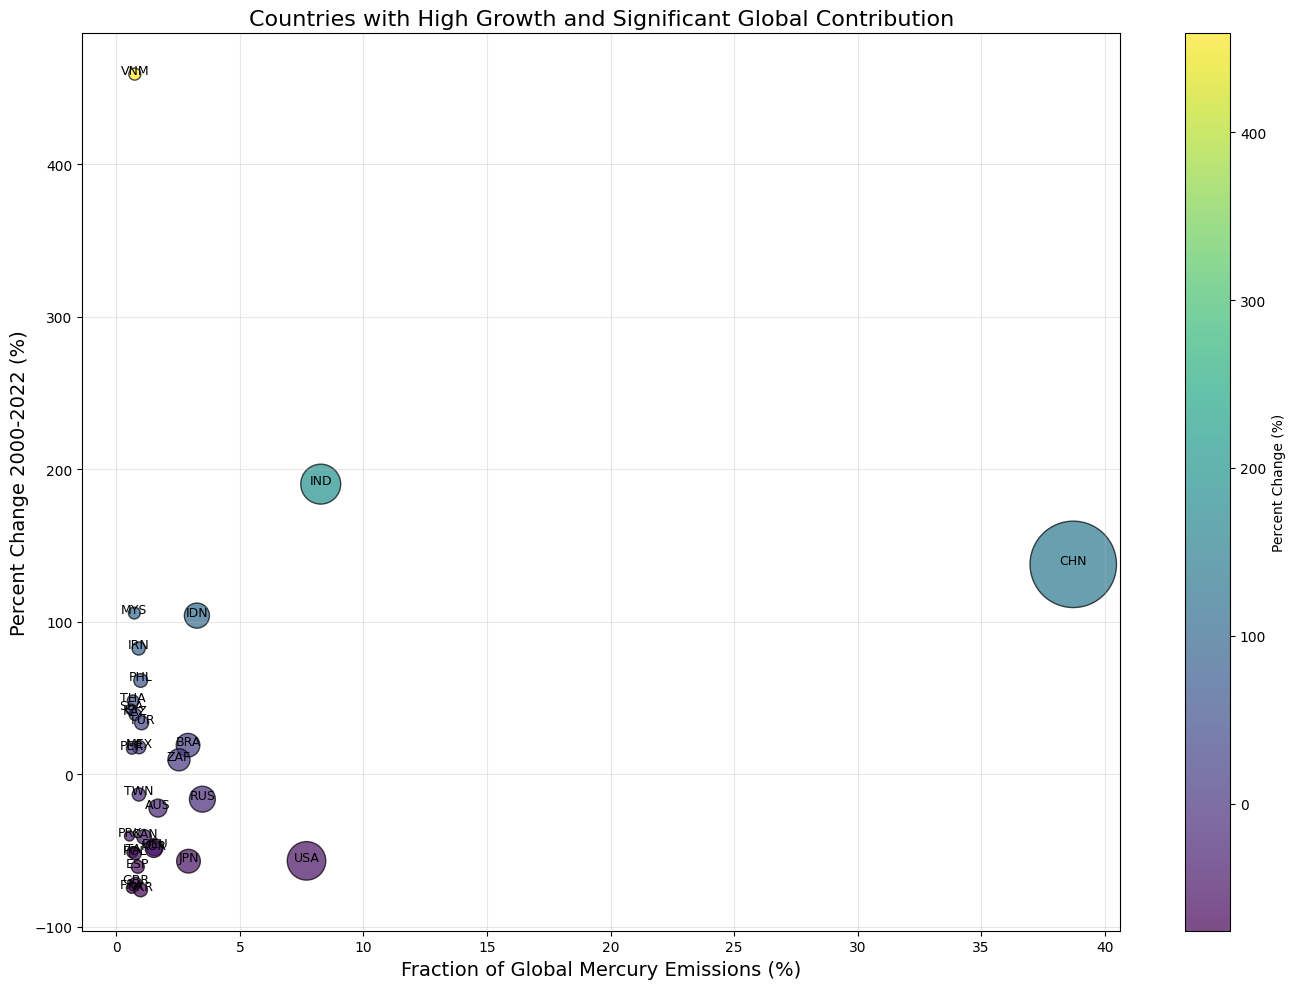

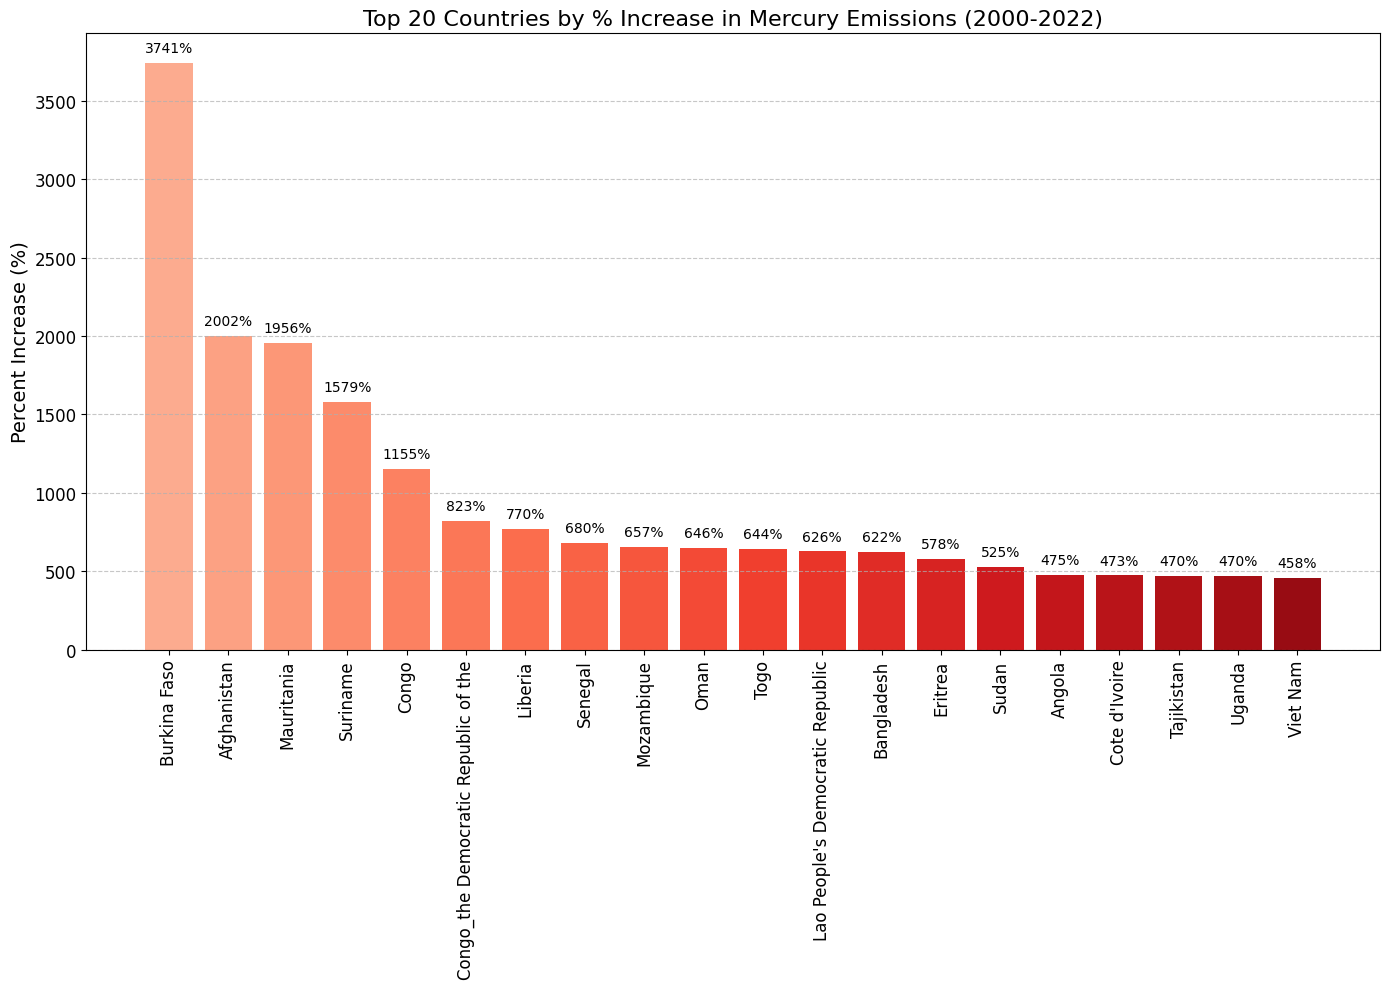

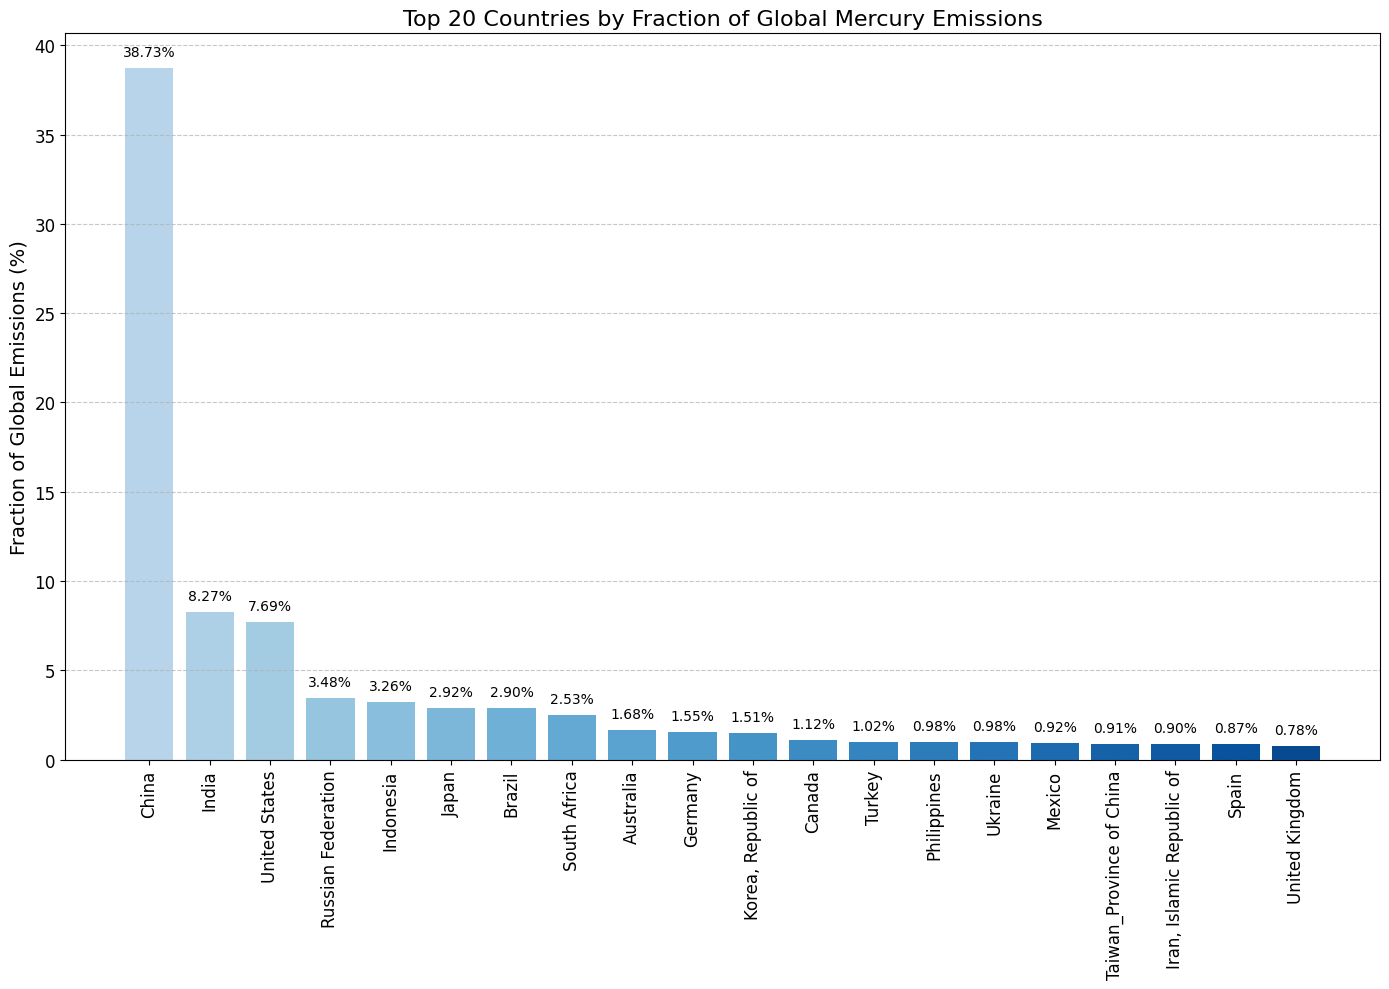

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.colors import LinearSegmentedColormap

# Load the Excel file
# Adjust the path to your file location
file_path = '/content/drive/My Drive/ColabDataFolders/Hg-EDGAR/Hg_D_m_2000_2022.xlsx'
df = pd.read_excel(file_path, header=0)

# Print dataset information
print("Dataset overview:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Convert monthly columns to numeric, handling any potential issues
month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for col in month_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate annual total for each entry (sum of all months)
df['annual_total'] = df[month_columns].sum(axis=1)

# -------------- COUNTRY ANALYSIS --------------

# Calculate country totals for 2000 and 2022
def calculate_country_stats():
    """Calculate country-level mercury emission statistics for 2000 and 2022"""

    # Aggregate emissions by country and year
    country_year_totals = df.groupby(['Country_code_A3', 'Name', 'Year'])['annual_total'].sum().reset_index()

    # Create a pivot table for years 2000 and 2022
    country_pivot = country_year_totals.pivot_table(
        index=['Country_code_A3', 'Name'],
        columns='Year',
        values='annual_total',
        fill_value=0
    ).reset_index()

    # Keep only countries that have data for both 2000 and 2022
    if 2000 in country_pivot.columns and 2022 in country_pivot.columns:
        country_pivot = country_pivot[country_pivot[2000] > 0][country_pivot[2022] > 0]

        # Rename columns for clarity
        country_stats = country_pivot.rename(columns={
            2000: '2000_value',
            2022: '2022_value'
        })

        # Calculate absolute and percentage changes
        country_stats['Absolute_change'] = country_stats['2022_value'] - country_stats['2000_value']
        country_stats['Percent_change'] = (country_stats['Absolute_change'] / country_stats['2000_value']) * 100

        # Sort by percentage change (descending)
        country_stats = country_stats.sort_values('Percent_change', ascending=False)

        return country_stats
    else:
        print("Data for years 2000 and/or 2022 not found")
        return None

# NEW FUNCTION: Calculate country aggregates across all years
def calculate_country_aggregates():
    """Calculate each country's total emissions across all years and their global fraction"""

    # Sum emissions by country across all years
    country_all_years = df.groupby(['Country_code_A3', 'Name'])['annual_total'].sum().reset_index()

    # Calculate world total emissions
    world_total = country_all_years['annual_total'].sum()

    # Calculate each country's fraction of global emissions
    country_all_years['total_hg_all_years'] = country_all_years['annual_total']
    country_all_years['fraction_of_global'] = (country_all_years['annual_total'] / world_total) * 100

    # Sort by fraction of global emissions (descending)
    country_all_years = country_all_years.sort_values('fraction_of_global', ascending=False)

    return country_all_years, world_total

# NEW FUNCTION: Identify interesting countries (high growth + significant contribution)
def identify_interesting_countries(country_totals, country_aggregates, min_fraction=0.5):
    """Identify countries with high growth rates and significant global contribution"""

    # Merge country_totals (which has percent change) with country_aggregates (which has global fraction)
    interesting_countries = pd.merge(
        country_totals,
        country_aggregates[['Country_code_A3', 'total_hg_all_years', 'fraction_of_global']],
        on='Country_code_A3',
        how='inner'
    )

    # Filter for countries with at least min_fraction of global emissions
    significant_countries = interesting_countries[interesting_countries['fraction_of_global'] >= min_fraction]

    # Sort by percent change (descending) to see fast-growing significant countries
    significant_countries = significant_countries.sort_values('Percent_change', ascending=False)

    return significant_countries

# Calculate regional statistics
def calculate_regional_stats():
    """Calculate regional mercury emission statistics"""

    # Aggregate emissions by region and year
    regional_year_totals = df.groupby(['C_group_IM24_sh', 'Year'])['annual_total'].sum().reset_index()

    # Create a pivot table for years 2000 and 2022
    regional_pivot = regional_year_totals.pivot_table(
        index='C_group_IM24_sh',
        columns='Year',
        values='annual_total',
        fill_value=0
    ).reset_index()

    # Keep only regions that have data for both 2000 and 2022
    if 2000 in regional_pivot.columns and 2022 in regional_pivot.columns:
        regional_pivot = regional_pivot[regional_pivot[2000] > 0][regional_pivot[2022] > 0]

        # Rename columns for clarity
        regional_stats = regional_pivot.rename(columns={
            2000: '2000_value',
            2022: '2022_value'
        })

        # Calculate absolute and percentage changes
        regional_stats['Absolute_change'] = regional_stats['2022_value'] - regional_stats['2000_value']
        regional_stats['Percent_change'] = (regional_stats['Absolute_change'] / regional_stats['2000_value']) * 100

        # Sort by percentage change (descending)
        regional_stats = regional_stats.sort_values('Percent_change', ascending=False)

        return regional_stats
    else:
        print("Data for years 2000 and/or 2022 not found")
        return None

# Run the analysis
try:
    # Original country analysis (2000 vs 2022)
    print("\nAnalyzing country-level mercury emissions (2000 vs 2022)...")
    country_totals = calculate_country_stats()

    # NEW: Calculate country aggregates across all years
    print("\nCalculating country aggregates across all years...")
    country_aggregates, world_total = calculate_country_aggregates()

    # Save country aggregates to CSV
    country_aggregates.to_csv('country_aggregates.csv', index=False)
    print(f"Saved country aggregates to 'country_aggregates.csv'")
    print(f"World total mercury emissions across all years: {world_total:.6e}")

    # Display top countries by fraction of global emissions
    print("\nTop 25 Countries by Fraction of Global Mercury Emissions:")
    print(country_aggregates.head(25)[['Country_code_A3', 'Name', 'total_hg_all_years', 'fraction_of_global']])

    # NEW: Identify interesting countries (high growth + significant contribution)
    print("\nIdentifying countries with high growth rates and significant global contribution (>0.5%)...")
    interesting_countries = identify_interesting_countries(country_totals, country_aggregates, min_fraction=0.5)

    # Save interesting countries to CSV
    interesting_countries.to_csv('interesting_countries.csv', index=False)
    print(f"Saved interesting countries to 'interesting_countries.csv'")

    # Display interesting countries
    print("\nCountries with High Growth Rates and Significant Global Contribution (>0.5%):")
    print(interesting_countries[['Country_code_A3', 'Name', 'Percent_change', 'fraction_of_global']])

    # Original: Save to CSV
    country_totals.to_csv('country_rankings.csv', index=False)
    print("Saved country rankings to 'country_rankings.csv'")

    # Calculate regional statistics
    print("\nAnalyzing regional mercury emissions...")
    regional_totals = calculate_regional_stats()

    # Save regional data to CSV
    regional_totals.to_csv('regional_rankings.csv', index=False)
    print("Saved regional rankings to 'regional_rankings.csv'")

    # -------------- VISUALIZATIONS --------------

    # Create visualizations directory if it doesn't exist
    if not os.path.exists('visualizations'):
        os.makedirs('visualizations')

    # NEW: Create visualization for countries with both high growth and significant contribution
    plt.figure(figsize=(14, 10))

    # Only keep countries with at least 0.5% of global emissions
    scatter_data = interesting_countries.copy()

    # Create a scatter plot with bubble size proportional to global fraction
    scatter = plt.scatter(
        scatter_data['fraction_of_global'],
        scatter_data['Percent_change'],
        s=scatter_data['fraction_of_global'] * 100,  # Scale for visibility
        c=scatter_data['Percent_change'],
        cmap='viridis',
        alpha=0.7,
        edgecolors='black',
        linewidth=1
    )

    # Add country labels
    for i, row in scatter_data.iterrows():
        plt.annotate(
            row['Country_code_A3'],
            (row['fraction_of_global'], row['Percent_change']),
            fontsize=9,
            ha='center'
        )

    plt.title('Countries with High Growth and Significant Global Contribution', fontsize=16)
    plt.xlabel('Fraction of Global Mercury Emissions (%)', fontsize=14)
    plt.ylabel('Percent Change 2000-2022 (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Percent Change (%)')

    plt.tight_layout()
    plt.savefig('visualizations/high_impact_countries.png', dpi=300, bbox_inches='tight')
    print("Saved high impact countries visualization to 'visualizations/high_impact_countries.png'")

    # 1. Create bar plot for top 20 countries by percent change
    plt.figure(figsize=(14, 10))
    top20 = country_totals.head(20).copy()

    # Create a color gradient based on percent change
    colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(top20)))

    bars = plt.bar(
        top20['Name'],
        top20['Percent_change'],
        color=colors
    )

    plt.title('Top 20 Countries by % Increase in Mercury Emissions (2000-2022)', fontsize=16)
    plt.ylabel('Percent Increase (%)', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 50,
            f'{int(height)}%',
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=0
        )

    plt.tight_layout()
    plt.savefig('visualizations/top20_percent_change.png', dpi=300, bbox_inches='tight')
    print("Saved bar chart to 'visualizations/top20_percent_change.png'")

    # NEW: Create bar chart for top 20 countries by global fraction
    plt.figure(figsize=(14, 10))
    top20_fraction = country_aggregates.head(20).copy()

    # Create a color gradient based on fraction
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(top20_fraction)))

    bars = plt.bar(
        top20_fraction['Name'],
        top20_fraction['fraction_of_global'],
        color=colors
    )

    plt.title('Top 20 Countries by Fraction of Global Mercury Emissions', fontsize=16)
    plt.ylabel('Fraction of Global Emissions (%)', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.5,
            f'{height:.2f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=0
        )

    plt.tight_layout()
    plt.savefig('visualizations/top20_global_fraction.png', dpi=300, bbox_inches='tight')
    print("Saved bar chart to 'visualizations/top20_global_fraction.png'")

except Exception as e:
    print(f"Error in analysis: {e}")

#new

In [29]:
# ──────────────────────────────────────────────────────────────────────────────
# 📦 Install required packages
!pip install geopandas contextily

# ──────────────────────────────────────────────────────────────────────────────
# 🚀 Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import drive

# ──────────────────────────────────────────────────────────────────────────────
# 🔌 Mount Drive & Load Data
drive.mount('/content/drive')
df = pd.read_excel(
    '/content/drive/My Drive/ColabDataFolders/Hg-EDGAR/Hg_D_m_2000_2022.xlsx',
    header=0
)

# ──────────────────────────────────────────────────────────────────────────────
# 📊 Preprocess: annual total
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df[months] = df[months].apply(pd.to_numeric, errors='coerce')
df['annual_total'] = df[months].sum(axis=1)

# ──────────────────────────────────────────────────────────────────────────────
# 🔢 Country stats: total & percent change
country_year = df.groupby(['Country_code_A3','Name','Year'])['annual_total'].sum().reset_index()
pivot = country_year.pivot_table(index=['Country_code_A3','Name'], columns='Year', values='annual_total', fill_value=0)
pivot = pivot[(pivot.get(2000,0)>0)&(pivot.get(2022,0)>0)].reset_index()
pivot['Absolute_change'] = pivot[2022] - pivot[2000]
pivot['Percent_change'] = pivot['Absolute_change']/pivot[2000]*100

country_totals = pivot.rename(columns={2000:'2000_value',2022:'2022_value'})
country_aggregates = df.groupby(['Country_code_A3','Name'])['annual_total'].sum().reset_index()
country_aggregates['total_hg_all_years'] = country_aggregates['annual_total']
world_total = country_aggregates['annual_total'].sum()
country_aggregates['fraction_of_global'] = country_aggregates['annual_total']/world_total*100

# ──────────────────────────────────────────────────────────────────────────────
# 🌍 Load world geometries & merge
world = gpd.read_file("https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json")

map_total = world.merge(country_aggregates, left_on='iso_a3', right_on='Country_code_A3', how='left')
map_pct = world.merge(country_totals[['Country_code_A3','Percent_change']], left_on='iso_a3', right_on='Country_code_A3', how='left')

# ──────────────────────────────────────────────────────────────────────────────
# 🎨 Plot function
def plot_choropleth(gdf, column, title, fname):
    fig, ax = plt.subplots(figsize=(16,8))
    gdf.plot(
        column=column,
        ax=ax,
        legend=True,
        scheme='quantiles',
        cmap='viridis',
        missing_kwds={'color':'lightgrey','label':'No data'}
    )
    ax.set_title(title, fontsize=20)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'visualizations/{fname}', dpi=300)
    plt.close()

# ──────────────────────────────────────────────────────────────────────────────
# 🖼️ Ensure output folder exists
import os
os.makedirs('visualizations', exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────────
# 📈 Generate maps
plot_choropleth(map_total, 'total_hg_all_years', 'Total Hg Emissions (2000–2022)', 'map_total_emissions.png')
plot_choropleth(map_pct,   'Percent_change', '% Change Hg Emissions (2000→2022)', 'map_percent_change.png')

print("✅ Completed — check /content/visualizations for your two PNGs.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: 'iso_a3'

In [39]:

# Load world geometries (ISO‑A3 codes are in the `id` field)
world = gpd.read_file(
    "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
)
map_total = world.merge(
    country_aggregates,
    left_on='id',
    right_on='Country_code_A3',
    how='left'
)

map_pct = world.merge(
    country_totals[['Country_code_A3','Percent_change']],
    left_on='id',
    right_on='Country_code_A3',
    how='left'
)



# ──────────────────────────────────────────────────────────────────────────────
# 🎨 Plot function
def plot_choropleth(gdf, column, title, fname):
    fig, ax = plt.subplots(figsize=(16,8))
    gdf.plot(
        column=column,
        ax=ax,
        legend=True,
        scheme='quantiles',
        cmap='viridis',
        missing_kwds={'color':'lightgrey','label':'No data'}
    )
    ax.set_title(title, fontsize=20)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'visualizations/{fname}', dpi=300)
    plt.close()

# ──────────────────────────────────────────────────────────────────────────────
# 🖼️ Ensure output folder exists
import os
os.makedirs('visualizations', exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────────
# 📈 Generate maps
plot_choropleth(map_total, 'total_hg_all_years', 'Total Hg Emissions (2000–2022)', 'map_total_emissions.png')
plot_choropleth(map_pct,   'Percent_change', '% Change Hg Emissions (2000→2022)', 'map_percent_change.png')

print("✅ Completed — check /content/visualizations for your two PNGs.")


✅ Completed — check /content/visualizations for your two PNGs.


In [38]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.4 MB/s eta 0:00:00


In [33]:
# Inspect column names and first few rows
print(world.columns.tolist())
print(world.head()[['id', 'properties']].head(5))


['iso_a3', 'name', 'geometry']


KeyError: "None of [Index(['id', 'properties'], dtype='object')] are in the [columns]"

In [34]:
print("World columns:", world.columns.tolist())
print("Country aggregate columns:", country_aggregates.columns.tolist())


World columns: ['iso_a3', 'name', 'geometry']
Country aggregate columns: ['Country_code_A3', 'Name', 'annual_total', 'total_hg_all_years', 'fraction_of_global']


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def create_mercury_world_map(file_path, output_dir='visualizations'):
    """
    Create comprehensive visualizations of mercury emissions on a world map

    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing mercury emissions data
    output_dir : str
        Directory to save the output visualizations
    """
    # Load the data
    df = pd.read_excel(file_path, header=0)

    # Convert monthly columns to numeric
    month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for col in month_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate annual total for each entry
    df['annual_total'] = df[month_columns].sum(axis=1)

    # --- Calculate country statistics ---

    # Aggregate emissions by country and year
    country_year_totals = df.groupby(['Country_code_A3', 'Name', 'Year'])['annual_total'].sum().reset_index()

    # Create a pivot table for years 2000 and 2022
    country_pivot = country_year_totals.pivot_table(
        index=['Country_code_A3', 'Name'],
        columns='Year',
        values='annual_total',
        fill_value=0
    ).reset_index()

    # Process data for years 2000 and 2022
    country_stats = country_pivot.copy()
    if 2000 in country_pivot.columns and 2022 in country_pivot.columns:
        # Rename columns for clarity
        country_stats = country_pivot.rename(columns={
            2000: '2000_value',
            2022: '2022_value'
        })

        # Calculate absolute and percentage changes
        country_stats['Absolute_change'] = country_stats['2022_value'] - country_stats['2000_value']
        country_stats['Percent_change'] = (country_stats['Absolute_change'] / country_stats['2000_value']) * 100

    # --- Calculate country aggregates across all years ---

    # Sum emissions by country across all years
    country_all_years = df.groupby(['Country_code_A3', 'Name'])['annual_total'].sum().reset_index()

    # Calculate world total emissions
    world_total = country_all_years['annual_total'].sum()

    # Calculate each country's fraction of global emissions
    country_all_years['total_hg_all_years'] = country_all_years['annual_total']
    country_all_years['fraction_of_global'] = (country_all_years['annual_total'] / world_total) * 100

    # --- Create a merged dataset with both metrics ---

    # Merge country statistics with country aggregates
    merged_data = pd.merge(
        country_stats,
        country_all_years[['Country_code_A3', 'fraction_of_global']],
        on='Country_code_A3',
        how='inner'
    )

    # --- Load world geometry data ---

    # Get world map data from geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Fix some country codes that might differ between datasets
    country_code_map = {
        'USA': 'USA', 'GBR': 'GBR', 'RUS': 'RUS', 'CHN': 'CHN', 'IND': 'IND',
        'AUS': 'AUS', 'BRA': 'BRA', 'CAN': 'CAN', 'ZAF': 'ZAF', 'DEU': 'DEU',
        # Add more mappings as needed
    }

    # Standardize country codes in the world dataframe
    world['iso_a3'] = world['iso_a3'].replace(country_code_map)

    # Merge the world geometry with mercury data
    world_data = world.merge(
        merged_data,
        left_on='iso_a3',
        right_on='Country_code_A3',
        how='left'
    )

    # --- Create Visualization 1: Percent Change Choropleth Map ---

    # Set up a custom diverging colormap for percent change
    # Blue for decreases, red for increases, white for no change
    cmap_change = LinearSegmentedColormap.from_list(
        'custom_div',
        [(0, 'darkblue'), (0.25, 'skyblue'), (0.5, 'white'),
         (0.75, 'orange'), (1, 'darkred')],
        N=256
    )

    fig1, ax1 = plt.subplots(1, 1, figsize=(16, 10))

    # Cap extreme values for better visualization
    world_data['Percent_change_capped'] = world_data['Percent_change'].clip(-200, 200)

    # Plot the choropleth map
    world_data.plot(
        column='Percent_change_capped',
        cmap=cmap_change,
        linewidth=0.5,
        ax=ax1,
        edgecolor='0.5',
        legend=True,
        missing_kwds={'color': 'lightgray'}
    )

    # Add a colorbar
    sm1 = plt.cm.ScalarMappable(cmap=cmap_change, norm=plt.Normalize(-200, 200))
    sm1._A = []
    cbar1 = fig1.colorbar(sm1, ax=ax1)
    cbar1.set_label('Percent Change in Mercury Emissions (2000-2022)', fontsize=12)

    # Set the title and other parameters
    ax1.set_title('Change in Mercury (Hg) Emissions by Country (2000-2022)', fontsize=16)
    ax1.set_axis_off()

    # Save the figure
    plt.savefig(f'{output_dir}/hg_percent_change_map.png', dpi=300, bbox_inches='tight')

    # --- Create Visualization 2: Global Contribution Choropleth Map ---

    # Set up a sequential colormap for global contribution
    cmap_contribution = 'YlOrRd'

    fig2, ax2 = plt.subplots(1, 1, figsize=(16, 10))

    # Use log scale for better visualization as global contribution is skewed
    world_data['log_fraction'] = np.log1p(world_data['fraction_of_global'])

    # Plot the choropleth map
    world_data.plot(
        column='log_fraction',
        cmap=cmap_contribution,
        linewidth=0.5,
        ax=ax2,
        edgecolor='0.5',
        legend=True,
        missing_kwds={'color': 'lightgray'}
    )

    # Create a custom colorbar with original (non-log) values
    bounds = [0, 0.1, 0.5, 1, 5, 10, 20, 30]
    norm = mcolors.BoundaryNorm(bounds, plt.get_cmap(cmap_contribution).N)
    sm2 = plt.cm.ScalarMappable(cmap=cmap_contribution, norm=norm)
    sm2._A = []
    cbar2 = fig2.colorbar(sm2, ax=ax2, boundaries=bounds, ticks=bounds)
    cbar2.set_label('Fraction of Global Mercury Emissions (%)', fontsize=12)

    # Set the title and other parameters
    ax2.set_title('Global Contribution of Mercury (Hg) Emissions by Country', fontsize=16)
    ax2.set_axis_off()

    # Save the figure
    plt.savefig(f'{output_dir}/hg_global_contribution_map.png', dpi=300, bbox_inches='tight')

    # --- Create Visualization 3: Combined Map (Bubble + Choropleth) ---

    fig3, ax3 = plt.subplots(1, 1, figsize=(18, 11))

    # Plot base map with global contribution as colors
    world_data.plot(
        column='fraction_of_global',
        cmap='YlOrRd',
        linewidth=0.5,
        ax=ax3,
        edgecolor='0.5',
        legend=False,
        missing_kwds={'color': 'lightgray'}
    )

    # Calculate centroids for bubble placement
    world_data['centroid'] = world_data.geometry.centroid

    # Define bubble size based on absolute change (positive or negative)
    # Use absolute value for size, and color for direction
    world_data['abs_change'] = np.abs(world_data['Absolute_change'])
    max_change = world_data['abs_change'].max()

    # Normalize bubble sizes
    world_data['bubble_size'] = 100 * np.sqrt(world_data['abs_change'] / max_change)

    # Plot bubbles for countries with significant change
    for idx, row in world_data.iterrows():
        if pd.notnull(row['Absolute_change']) and abs(row['Absolute_change']) > 0:
            x, y = row['centroid'].x, row['centroid'].y
            size = row['bubble_size']

            # Set color based on direction of change
            if row['Absolute_change'] > 0:
                color = 'red'
                edge_color = 'darkred'
            else:
                color = 'blue'
                edge_color = 'darkblue'

            # Add bubble
            ax3.scatter(
                x, y,
                s=size,
                c=color,
                alpha=0.6,
                edgecolors=edge_color,
                linewidth=1
            )

            # Add label for major countries (those with large global contribution)
            if row['fraction_of_global'] > 3:
                ax3.text(
                    x, y,
                    row['iso_a3'],
                    fontsize=8,
                    ha='center',
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2')
                )

    # Create custom colorbar for choropleth
    cmap_contrib = plt.get_cmap('YlOrRd')
    norm_contrib = mcolors.Normalize(vmin=0, vmax=30)
    sm_contrib = plt.cm.ScalarMappable(cmap=cmap_contrib, norm=norm_contrib)
    sm_contrib._A = []
    cbar_contrib = fig3.colorbar(sm_contrib, ax=ax3, location='bottom', shrink=0.6, pad=0.05)
    cbar_contrib.set_label('Fraction of Global Mercury Emissions (%)', fontsize=12)

    # Create custom legend for bubbles
    increase_patch = mpatches.Patch(color='red', alpha=0.6, label='Increase in Emissions')
    decrease_patch = mpatches.Patch(color='blue', alpha=0.6, label='Decrease in Emissions')

    # Create bubble size legend
    size_values = [max_change * 0.01, max_change * 0.1, max_change * 0.5]
    size_labels = ['Small Change', 'Medium Change', 'Large Change']
    size_bubbles = []

    for size_val in size_values:
        size_scaled = 100 * np.sqrt(size_val / max_change)
        size_bubbles.append(
            mlines.Line2D(
                [], [],
                marker='o',
                color='gray',
                markerfacecolor='gray',
                markersize=np.sqrt(size_scaled/np.pi),
                linestyle='None',
                label=f'{size_val:.2e}'
            )
        )

    # Combine legends
    ax3.legend(
        handles=[increase_patch, decrease_patch, *size_bubbles],
        loc='lower left',
        title='Legend',
        fontsize=10,
        title_fontsize=12
    )

    # Set the title and other parameters
    ax3.set_title('Mercury (Hg) Emissions: Global Contribution and 2000-2022 Change', fontsize=16)
    ax3.set_axis_off()

    # Add caption with explanation
    fig3.text(
        0.5, 0.01,
        'Color intensity shows contribution to global emissions. ' +
        'Bubbles show absolute change (red = increase, blue = decrease). ' +
        'Bubble size represents magnitude of change.',
        fontsize=10,
        ha='center'
    )

    # Save the figure
    plt.savefig(f'{output_dir}/hg_combined_map.png', dpi=300, bbox_inches='tight')

    print(f"Created and saved three mercury emission world maps in {output_dir}:")
    print(f"1. {output_dir}/hg_percent_change_map.png - Percent change in emissions (2000-2022)")
    print(f"2. {output_dir}/hg_global_contribution_map.png - Fraction of global emissions")
    print(f"3. {output_dir}/hg_combined_map.png - Combined visualization with both metrics")

    return {
        'percent_change_map': f'{output_dir}/hg_percent_change_map.png',
        'global_contribution_map': f'{output_dir}/hg_global_contribution_map.png',
        'combined_map': f'{output_dir}/hg_combined_map.png'
    }

# Example usage:
create_mercury_world_map('/path/to/Hg_D_m_2000_2022.xlsx', 'visualizations')

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/Hg_D_m_2000_2022.xlsx'

In [22]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.4 MB/s eta 0:00:00


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import contextily as ctx
import os
import requests
import tempfile
from zipfile import ZipFile
from io import BytesIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

def download_world_map():
    """
    Download the Natural Earth low resolution countries dataset

    Returns:
    --------
    geopandas.GeoDataFrame with world countries
    """
    # URL for the Natural Earth low resolution countries dataset
    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"

    # Download the data
    print("Downloading Natural Earth data...")
    response = requests.get(url)

    # Check if the download was successful
    if response.status_code != 200:
        raise Exception(f"Failed to download data: {response.status_code}")

    # Create a temporary directory to extract the zip file
    with tempfile.TemporaryDirectory() as tmpdir:
        # Extract the zip file
        zip_file = ZipFile(BytesIO(response.content))
        zip_file.extractall(tmpdir)

        # Find the shapefile
        shp_files = [f for f in os.listdir(tmpdir) if f.endswith('.shp')]
        if not shp_files:
            raise Exception("No shapefile found in the downloaded data")

        # Load the shapefile
        shapefile_path = os.path.join(tmpdir, shp_files[0])
        world = gpd.read_file(shapefile_path)

    return world

def create_mercury_world_map_overlay(file_path, output_dir='visualizations'):
    """
    Create mercury emissions visualizations overlaid on physical world maps

    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing mercury emissions data
    output_dir : str
        Directory to save the output visualizations
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the data
    df = pd.read_excel(file_path, header=0)

    # Convert monthly columns to numeric
    month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for col in month_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate annual total for each entry
    df['annual_total'] = df[month_columns].sum(axis=1)

    # --- Calculate country statistics ---

    # Aggregate emissions by country and year
    country_year_totals = df.groupby(['Country_code_A3', 'Name', 'Year'])['annual_total'].sum().reset_index()

    # Create a pivot table for years 2000 and 2022
    country_pivot = country_year_totals.pivot_table(
        index=['Country_code_A3', 'Name'],
        columns='Year',
        values='annual_total',
        fill_value=0
    ).reset_index()

    # Process data for years 2000 and 2022
    country_stats = country_pivot.copy()
    if 2000 in country_pivot.columns and 2022 in country_pivot.columns:
        # Rename columns for clarity
        country_stats = country_pivot.rename(columns={
            2000: '2000_value',
            2022: '2022_value'
        })

        # Calculate absolute and percentage changes
        country_stats['Absolute_change'] = country_stats['2022_value'] - country_stats['2000_value']
        country_stats['Percent_change'] = (country_stats['Absolute_change'] / country_stats['2000_value']) * 100

    # --- Calculate country aggregates across all years ---

    # Sum emissions by country across all years
    country_all_years = df.groupby(['Country_code_A3', 'Name'])['annual_total'].sum().reset_index()

    # Calculate world total emissions
    world_total = country_all_years['annual_total'].sum()

    # Calculate each country's fraction of global emissions
    country_all_years['total_hg_all_years'] = country_all_years['annual_total']
    country_all_years['fraction_of_global'] = (country_all_years['annual_total'] / world_total) * 100

    # --- Create a merged dataset with both metrics ---

    # Merge country statistics with country aggregates
    merged_data = pd.merge(
        country_stats,
        country_all_years[['Country_code_A3', 'fraction_of_global']],
        on='Country_code_A3',
        how='inner'
    )

    # --- Load world geometry data ---

    # Download the world map data
    world = download_world_map()

    # Create a crosswalk between Natural Earth country codes and your data
    # Natural Earth uses ISO_A3 for country codes
    world['iso_a3'] = world['ISO_A3']

    # Convert the CRS to Web Mercator for compatibility with contextily basemaps
    world = world.to_crs(epsg=3857)

    # Merge the world geometry with mercury data
    world_data = world.merge(
        merged_data,
        left_on='iso_a3',
        right_on='Country_code_A3',
        how='left'
    )

    # --- Visualization 1: Percent Change Choropleth Map with Physical Basemap ---

    fig1, ax1 = plt.subplots(1, 1, figsize=(18, 12))

    # Cap extreme values for better visualization
    world_data['Percent_change_capped'] = world_data['Percent_change'].clip(-200, 200)

    # Define a diverging colormap for percent change
    cmap_change = LinearSegmentedColormap.from_list(
        'custom_div',
        [(0, 'darkblue'), (0.25, 'royalblue'), (0.5, 'white'),
         (0.75, 'orange'), (1, 'darkred')],
        N=256
    )

    # Plot the choropleth map with transparency to let the basemap show through
    world_data.plot(
        column='Percent_change_capped',
        cmap=cmap_change,
        linewidth=0.5,
        ax=ax1,
        edgecolor='0.5',
        legend=False,
        missing_kwds={'color': 'lightgray', 'alpha': 0.5},
        alpha=0.7
    )

    # Add the physical basemap
    ctx.add_basemap(
        ax1,
        source=ctx.providers.CartoDB.Positron,  # Clean, light background
        alpha=0.8  # Slightly transparent to blend with the choropleth
    )

    # Add a colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    sm1 = plt.cm.ScalarMappable(cmap=cmap_change, norm=plt.Normalize(-200, 200))
    sm1._A = []
    cbar1 = fig1.colorbar(sm1, cax=cax)
    cbar1.set_label('Percent Change in Mercury Emissions (2000-2022)', fontsize=14)

    # Set the title
    ax1.set_title('Change in Mercury (Hg) Emissions by Country (2000-2022)', fontsize=18)

    # Remove axis labels but keep the frame
    ax1.set_axis_off()

    # Add a caption explaining the visualization
    fig1.text(
        0.5, 0.01,
        'Blue indicates decrease in emissions, red indicates increase. Color intensity shows magnitude of change.',
        fontsize=12,
        ha='center'
    )

    # Save the figure
    plt.savefig(f'{output_dir}/hg_percent_change_physical_map.png', dpi=300, bbox_inches='tight')
    plt.close(fig1)

    # --- Visualization 2: Global Contribution Choropleth Map with Physical Basemap ---

    fig2, ax2 = plt.subplots(1, 1, figsize=(18, 12))

    # Define a sequential colormap for global contribution
    cmap_contribution = 'YlOrRd'

    # Plot the choropleth map with transparency
    world_data.plot(
        column='fraction_of_global',
        cmap=cmap_contribution,
        linewidth=0.5,
        ax=ax2,
        edgecolor='0.5',
        legend=False,
        missing_kwds={'color': 'lightgray', 'alpha': 0.5},
        alpha=0.7
    )

    # Add the physical basemap
    ctx.add_basemap(
        ax2,
        source=ctx.providers.CartoDB.Positron,
        alpha=0.8
    )

    # Add a colorbar
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="2%", pad=0.1)

    # Create a custom color normalization for better visualization
    # Use logarithmic scale for the colorbar since contribution is highly skewed
    bounds = [0, 0.1, 0.5, 1, 5, 10, 20, 30]
    norm = mcolors.BoundaryNorm(bounds, plt.get_cmap(cmap_contribution).N)
    sm2 = plt.cm.ScalarMappable(cmap=cmap_contribution, norm=norm)
    sm2._A = []
    cbar2 = fig2.colorbar(sm2, cax=cax2, boundaries=bounds, ticks=bounds)
    cbar2.set_label('Fraction of Global Mercury Emissions (%)', fontsize=14)

    # Set the title
    ax2.set_title('Global Contribution of Mercury (Hg) Emissions by Country', fontsize=18)

    # Remove axis labels but keep the frame
    ax2.set_axis_off()

    # Add a caption explaining the visualization
    fig2.text(
        0.5, 0.01,
        'Darker colors indicate higher contribution to global mercury emissions.',
        fontsize=12,
        ha='center'
    )

    # Save the figure
    plt.savefig(f'{output_dir}/hg_global_contribution_physical_map.png', dpi=300, bbox_inches='tight')
    plt.close(fig2)

    # --- Visualization 3: Combined Map (both metrics) with Physical Basemap ---

    fig3, ax3 = plt.subplots(1, 1, figsize=(18, 12))

    # Plot base map with global contribution as colors
    world_data.plot(
        column='fraction_of_global',
        cmap='YlOrRd',
        linewidth=0.5,
        ax=ax3,
        edgecolor='0.3',
        legend=False,
        missing_kwds={'color': 'lightgray', 'alpha': 0.5},
        alpha=0.6
    )

    # Add the physical basemap
    ctx.add_basemap(
        ax3,
        source=ctx.providers.Stamen.Terrain,  # Terrain map for more physical features
        alpha=0.7
    )

    # Calculate centroids for bubble placement
    world_data['centroid'] = world_data.geometry.centroid

    # Define bubble size based on absolute change (positive or negative)
    world_data['abs_change'] = np.abs(world_data['Absolute_change'])
    max_change = world_data['abs_change'].max()

    # Normalize bubble sizes (square root for better visual scaling)
    world_data['bubble_size'] = 200 * np.sqrt(world_data['abs_change'] / max_change)

    # Plot bubbles for countries with significant change
    for idx, row in world_data.iterrows():
        if pd.notnull(row['Absolute_change']) and abs(row['Absolute_change']) > 0:
            x, y = row['centroid'].x, row['centroid'].y
            size = row['bubble_size']

            # Set color based on direction of change with better visibility
            if row['Absolute_change'] > 0:
                color = 'red'
                edge_color = 'black'
            else:
                color = 'blue'
                edge_color = 'black'

            # Add bubble with black outline for better visibility
            ax3.scatter(
                x, y,
                s=size,
                c=color,
                alpha=0.7,
                edgecolors=edge_color,
                linewidth=1
            )

            # Add label for major countries (those with large global contribution)
            if pd.notnull(row['fraction_of_global']) and row['fraction_of_global'] > 3:
                ax3.text(
                    x, y,
                    row['iso_a3'],
                    fontsize=10,
                    ha='center',
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2', edgecolor='black')
                )

    # Add a colorbar for global contribution
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="2%", pad=0.1)

    bounds = [0, 0.1, 0.5, 1, 5, 10, 20, 30]
    norm = mcolors.BoundaryNorm(bounds, plt.get_cmap('YlOrRd').N)
    sm3 = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
    sm3._A = []
    cbar3 = fig3.colorbar(sm3, cax=cax3, boundaries=bounds, ticks=bounds)
    cbar3.set_label('Fraction of Global Mercury Emissions (%)', fontsize=14)

    # Create custom legend for bubbles
    increase_patch = mpatches.Patch(color='red', alpha=0.7, label='Increase in Emissions')
    decrease_patch = mpatches.Patch(color='blue', alpha=0.7, label='Decrease in Emissions')

    # Create bubble size legend
    size_values = [max_change * 0.01, max_change * 0.1, max_change * 0.5]
    size_labels = ['Small Change', 'Medium Change', 'Large Change']
    size_bubbles = []

    for size_val in size_values:
        size_scaled = 200 * np.sqrt(size_val / max_change)
        size_bubbles.append(
            plt.scatter(
                [], [],
                s=size_scaled,
                c='gray',
                alpha=0.7,
                edgecolors='black',
                label=f'{size_val:.2e}'
            )
        )

    # Add the legend
    leg = ax3.legend(
        handles=[increase_patch, decrease_patch, *size_bubbles],
        loc='lower left',
        title='Legend',
        fontsize=12,
        title_fontsize=14,
        frameon=True,
        framealpha=0.9
    )

    # Set the title
    ax3.set_title('Mercury (Hg) Emissions: Global Contribution and 2000-2022 Change', fontsize=18)

    # Remove axis labels but keep the frame
    ax3.set_axis_off()

    # Add a caption explaining the visualization
    fig3.text(
        0.5, 0.01,
        'Background color intensity shows contribution to global emissions. ' +
        'Bubbles show absolute change (red = increase, blue = decrease). ' +
        'Bubble size represents magnitude of change.',
        fontsize=12,
        ha='center'
    )

    # Save the figure
    plt.savefig(f'{output_dir}/hg_combined_physical_map.png', dpi=300, bbox_inches='tight')
    plt.close(fig3)

    # --- Create Visualization 4: Satellite View ---

    fig4, ax4 = plt.subplots(1, 1, figsize=(18, 12))

    # Plot countries with white borders for satellite view
    world_data.plot(
        ax=ax4,
        color='none',
        edgecolor='white',
        linewidth=0.5,
        alpha=0.7
    )

    # Add a satellite imagery basemap
    ctx.add_basemap(
        ax4,
        source=ctx.providers.Esri.WorldImagery,
        alpha=1.0
    )

    # Plot the centroids as point data
    for idx, row in world_data.iterrows():
        if pd.notnull(row['fraction_of_global']) and row['fraction_of_global'] > 1:
            x, y = row['centroid'].x, row['centroid'].y

            # Size based on global contribution
            size = row['fraction_of_global'] * 50

            # Color based on percent change
            if pd.notnull(row['Percent_change']):
                if row['Percent_change'] > 0:
                    color = 'red'
                else:
                    color = 'blue'
                intensity = min(1.0, abs(row['Percent_change']) / 200)
                alpha = 0.3 + 0.7 * intensity
            else:
                color = 'gray'
                alpha = 0.5

            # Add point
            ax4.scatter(
                x, y,
                s=size,
                c=color,
                alpha=alpha,
                edgecolors='white',
                linewidth=1
            )

            # Add label for significant countries
            if row['fraction_of_global'] > 3:
                ax4.text(
                    x, y,
                    row.get('NAME', row.get('iso_a3', '')),  # Try different field names
                    fontsize=10,
                    ha='center',
                    va='center',
                    color='white',
                    bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.2')
                )

    # Set title
    ax4.set_title('Mercury Emissions with Satellite Imagery Background', fontsize=18)

    # Remove axis labels
    ax4.set_axis_off()

    # Save the figure
    plt.savefig(f'{output_dir}/hg_satellite_map.png', dpi=300, bbox_inches='tight')
    plt.close(fig4)

    print(f"Created and saved four mercury emission world maps in {output_dir}:")
    print(f"1. {output_dir}/hg_percent_change_physical_map.png - Percent change overlaid on physical map")
    print(f"2. {output_dir}/hg_global_contribution_physical_map.png - Global contribution overlaid on physical map")
    print(f"3. {output_dir}/hg_combined_physical_map.png - Combined visualization on physical map")
    print(f"4. {output_dir}/hg_satellite_map.png - Visualization with satellite imagery background")

    return {
        'percent_change_map': f'{output_dir}/hg_percent_change_physical_map.png',
        'global_contribution_map': f'{output_dir}/hg_global_contribution_physical_map.png',
        'combined_map': f'{output_dir}/hg_combined_physical_map.png',
        'satellite_map': f'{output_dir}/hg_satellite_map.png'
    }

# Example usage:
create_mercury_world_map_overlay(file_path, 'visualizations')

Exception: Failed to download data: 406

In [14]:
import pandas as pd
import json
import os
from IPython.display import HTML, display
from google.colab import files

# Load the data
try:
    countries_data = pd.read_csv('visualizations/top25_countries.csv')
    print(f"Loaded data for {len(countries_data)} countries")

    # Convert country codes to dict for JavaScript
    countries_list = countries_data.to_dict('records')

    # Load summary statistics
    try:
        with open('visualizations/summary_stats.json', 'r') as f:
            summary_stats = json.load(f)[0]  # Get the first (and only) record
    except FileNotFoundError:
        # Default values if summary stats file not found
        summary_stats = {
            'max_percent_change': float(countries_data['Percent_change'].max()),
            'min_percent_change': float(countries_data['Percent_change'].min()),
            'max_2022_value': float(countries_data['2022_value'].max()),
            'min_2022_value': float(countries_data['2022_value'].min()),
            'max_absolute_change': float(countries_data['Absolute_change'].max()),
            'min_absolute_change': float(countries_data['Absolute_change'].min())
        }

    # Create HTML/JS visualization code
    html_content = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Mercury Emissions Analysis (2000-2022)</title>
    <!-- Load D3.js and TopoJSON libraries -->
    <script src="https://d3js.org/d3.v7.min.js"></script>
    <script src="https://d3js.org/topojson.v3.min.js"></script>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background-color: #f0f8ff;
            margin: 0;
            padding: 20px;
            color: #333;
        }

        .container {
            max-width: 1200px;
            margin: 0 auto;
            background-color: white;
            border-radius: 8px;
            box-shadow: 0 4px 12px rgba(0,0,0,0.1);
            padding: 20px;
        }

        h1, h2, h3 {
            text-align: center;
            color: #2c3e50;
        }

        h1 {
            margin-top: 10px;
            margin-bottom: 5px;
            font-size: 28px;
        }

        h2 {
            font-size: 18px;
            margin-top: 0;
            margin-bottom: 20px;
            font-weight: normal;
            color: #7f8c8d;
        }

        h3 {
            font-size: 20px;
            margin-top: 30px;
        }

        .map-container {
            position: relative;
            margin-bottom: 30px;
        }

        svg {
            display: block;
            margin: 0 auto;
            border: 1px solid #ddd;
            border-radius: 4px;
            background-color: #e6f2ff;
        }

        .country {
            fill: #d3d3d3;
            stroke: #fff;
            stroke-width: 0.5px;
        }

        .country:hover {
            fill: #b3b3b3;
        }

        .bubble {
            stroke: #333;
            stroke-width: 0.5;
            stroke-opacity: 0.8;
            cursor: pointer;
            transition: fill-opacity 0.3s;
        }

        .bubble:hover {
            stroke-width: 1.5;
            fill-opacity: 0.9 !important;
        }

        .country-label {
            pointer-events: none;
            font-size: 10px;
            font-weight: bold;
            text-shadow: 1px 1px 1px #fff, -1px -1px 1px #fff, 1px -1px 1px #fff, -1px 1px 1px #fff;
        }

        .tooltip {
            position: absolute;
            padding: 10px;
            background-color: rgba(0, 0, 0, 0.8);
            color: white;
            border-radius: 4px;
            pointer-events: none;
            font-size: 14px;
            max-width: 250px;
            z-index: 100;
            visibility: hidden;
        }

        .tooltip-title {
            font-weight: bold;
            margin-bottom: 5px;
            border-bottom: 1px solid #aaa;
            padding-bottom: 5px;
        }

        .tooltip-value {
            margin: 2px 0;
        }

        .controls {
            display: flex;
            justify-content: center;
            margin-bottom: 20px;
        }

        .controls button {
            margin: 0 5px;
            padding: 8px 15px;
            background-color: #3498db;
            color: white;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            transition: background-color 0.3s;
        }

        .controls button:hover {
            background-color: #2980b9;
        }

        .controls button.active {
            background-color: #2c3e50;
        }

        .legend {
            display: flex;
            flex-direction: column;
            position: absolute;
            bottom: 20px;
            right: 20px;
            background-color: rgba(255, 255, 255, 0.9);
            padding: 10px;
            border-radius: 4px;
            border: 1px solid #ddd;
        }

        .legend-title {
            font-weight: bold;
            margin-bottom: 5px;
            font-size: 14px;
            text-align: center;
        }

        .legend-item {
            display: flex;
            align-items: center;
            margin: 3px 0;
        }

        .legend-color {
            width: 20px;
            height: 20px;
            border-radius: 50%;
            margin-right: 8px;
            border: 1px solid #333;
        }

        .legend-label {
            font-size: 12px;
        }

        .data-table {
            width: 100%;
            border-collapse: collapse;
            margin-top: 30px;
            font-size: 14px;
        }

        .data-table th, .data-table td {
            padding: 10px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }

        .data-table th {
            background-color: #f2f2f2;
            font-weight: bold;
        }

        .data-table tbody tr:hover {
            background-color: #f5f5f5;
        }

        .data-table td.numeric {
            text-align: right;
            font-family: monospace;
        }

        .data-table td.highlight {
            font-weight: bold;
        }

        .pulse {
            animation: pulse 1.5s infinite;
        }

        @keyframes pulse {
            0% {
                transform: scale(0.95);
                box-shadow: 0 0 0 0 rgba(255, 0, 0, 0.7);
            }

            70% {
                transform: scale(1);
                box-shadow: 0 0 0 10px rgba(255, 0, 0, 0);
            }

            100% {
                transform: scale(0.95);
                box-shadow: 0 0 0 0 rgba(255, 0, 0, 0);
            }
        }

        .footer {
            margin-top: 30px;
            text-align: center;
            font-size: 14px;
            color: #7f8c8d;
        }

        /* Responsive design */
        @media (max-width: 768px) {
            .container {
                padding: 10px;
            }

            .controls {
                flex-wrap: wrap;
            }

            .controls button {
                margin: 5px;
            }

            .legend {
                position: static;
                margin: 20px auto;
                max-width: 300px;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Mercury (Hg) Emissions Global Analysis</h1>
        <h2>Changes from 2000 to 2022</h2>

        <div class="controls">
            <button id="btn-percent" class="active">% Change</button>
            <button id="btn-absolute">Absolute Change</button>
            <button id="btn-2022">2022 Emissions</button>
        </div>

        <div class="map-container">
            <svg id="map" width="960" height="500"></svg>
            <div id="tooltip" class="tooltip"></div>

            <div class="legend">
                <div class="legend-title" id="legend-title">% Change (2000-2022)</div>
                <div id="legend-content"></div>
            </div>
        </div>

        <h3>Top 25 Countries by Mercury Emission Change</h3>
        <table id="data-table" class="data-table">
            <thead>
                <tr>
                    <th>Rank</th>
                    <th>Country</th>
                    <th>2000 Emissions</th>
                    <th>2022 Emissions</th>
                    <th>Absolute Change</th>
                    <th>% Change</th>
                </tr>
            </thead>
            <tbody id="table-body">
                <!-- Data will be filled by JavaScript -->
            </tbody>
        </table>

        <div class="footer">
            <p>Source: EDGAR Mercury (Hg) Emissions Database, 2000-2022</p>
        </div>
    </div>

    <script>
        // Country data from Python
        const countriesData = COUNTRIES_DATA_PLACEHOLDER;

        // Summary statistics
        const summaryStats = SUMMARY_STATS_PLACEHOLDER;

        // Format scientific notation in a readable way
        function formatScientific(value) {
            if (value < 0.000001) {
                return (value * 1e9).toFixed(2) + " ng";
            } else if (value < 0.001) {
                return (value * 1e6).toFixed(2) + " μg";
            } else {
                return (value * 1e3).toFixed(2) + " mg";
            }
        }

        // Function to format percentage
        function formatPercent(value) {
            return value.toFixed(1) + "%";
        }

        // Country coordinates (approximate, for countries in our dataset)
        const countryCoordinates = {
            // This map will be populated with actual countries from our dataset
            // with their respective coordinates
            "USA": [-95.7129, 37.0902],
            "CHN": [104.1954, 35.8617],
            "RUS": [105.3188, 61.5240],
            "BRA": [-51.9253, -14.2350],
            "IND": [78.9629, 20.5937],
            "ZAF": [22.9375, -30.5595],
            "IDN": [113.9213, -0.7893],
            "SAU": [45.0792, 23.8859],
            "IRN": [53.6880, 32.4279],
            "MEX": [-102.5528, 23.6345],
            "TUR": [35.2433, 38.9637],
            "AUS": [133.7751, -25.2744],
            "THA": [100.9925, 15.8700],
            "MYS": [101.9758, 4.2105],
            "UKR": [31.1656, 48.3794],
            "VNM": [108.2772, 14.0583],
            "KAZ": [66.9237, 48.0196],
            "ARG": [-63.6167, -38.4161],
            "DZA": [1.6596, 28.0339],
            "PHL": [121.7740, 12.8797],
            "NGA": [8.6753, 9.0820],
            "PAK": [69.3451, 30.3753],
            "VEN": [-66.5897, 6.4238],
            "ARE": [53.8478, 23.4241],
            "EGY": [30.8025, 26.8206],
            "MNG": [103.8467, 46.8625],
            "COL": [-74.2973, 4.5709],
            "CHL": [-71.5429, -35.6751],
            "UZB": [64.5853, 41.3775],
            "MYS": [101.9758, 4.2105],
            "PER": [-75.0152, -9.1900],
            "BGD": [90.3563, 23.6850],
            "GRL": [-42.6043, 71.7069],
            "SUR": [-56.0278, 3.9193],
            "LAO": [102.4955, 19.8563],
            "BRN": [114.7277, 4.5353],
            "MRT": [-10.9408, 21.0079],
            "OMN": [55.9754, 21.4735],
            "TJK": [71.2761, 38.8610],
            "BFA": [-1.6880, 12.2383],
            "COG": [15.8277, -0.2280],
            "IRQ": [43.7792, 33.2232],
            "KHM": [104.9910, 12.5657],
            "GHA": [-1.0232, 7.9465],
            "AZE": [47.5769, 40.1431],
            "QAT": [51.1839, 25.3548],
            "AGO": [17.8739, -11.2027]
        };

        // Set up the map
        const width = 960;
        const height = 500;
        let currentMode = 'percent'; // Default visualization mode

        // Create the SVG
        const svg = d3.select("#map");
        const projection = d3.geoNaturalEarth1()
            .scale(width / 2 / Math.PI)
            .translate([width / 2, height / 2]);
        const path = d3.geoPath().projection(projection);

        // Create tooltip
        const tooltip = d3.select("#tooltip");

        // Create color scales for each mode
        const percentColorScale = d3.scaleSequential(d3.interpolateReds)
            .domain([0, summaryStats.max_percent_change]);

        const absoluteColorScale = d3.scaleSequential(d3.interpolateBlues)
            .domain([0, summaryStats.max_absolute_change]);

        const valueColorScale = d3.scaleSequential(d3.interpolateGreens)
            .domain([0, summaryStats.max_2022_value]);

        // Size scale for bubbles
        const bubbleSizeScale = d3.scaleSqrt()
            .domain([0, summaryStats.max_2022_value])
            .range([4, 40]);

        // Helper function to get coordinates for a country
        function getCountryCoordinates(countryCode) {
            return countryCoordinates[countryCode] || [0, 0]; // Default to [0,0] if not found
        }

        // Load the world map
        d3.json("https://cdn.jsdelivr.net/npm/world-atlas@2/countries-110m.json").then(world => {
            // Draw the world map
            const countries = topojson.feature(world, world.objects.countries).features;

            svg.selectAll(".country")
                .data(countries)
                .enter()
                .append("path")
                .attr("class", "country")
                .attr("d", path);

            // Initial visualization
            updateVisualization();
            updateDataTable();
            updateLegend();

            // Button event listeners
            document.getElementById("btn-percent").addEventListener("click", function() {
                currentMode = 'percent';
                updateActiveButton();
                updateVisualization();
                updateDataTable();
                updateLegend();
            });

            document.getElementById("btn-absolute").addEventListener("click", function() {
                currentMode = 'absolute';
                updateActiveButton();
                updateVisualization();
                updateDataTable();
                updateLegend();
            });

            document.getElementById("btn-2022").addEventListener("click", function() {
                currentMode = '2022';
                updateActiveButton();
                updateVisualization();
                updateDataTable();
                updateLegend();
            });
        });

        // Function to update the active button
        function updateActiveButton() {
            document.querySelectorAll(".controls button").forEach(btn => {
                btn.classList.remove("active");
            });

            let buttonId;
            if (currentMode === 'percent') {
                buttonId = "btn-percent";
            } else if (currentMode === 'absolute') {
                buttonId = "btn-absolute";
            } else {
                buttonId = "btn-2022";
            }

            document.getElementById(buttonId).classList.add("active");
        }

        // Function to update the visualization
        function updateVisualization() {
            // Remove any existing bubbles
            svg.selectAll(".bubble").remove();
            svg.selectAll(".country-label").remove();

            // Draw bubbles based on current mode
            svg.selectAll(".bubble")
                .data(countriesData)
                .enter()
                .append("circle")
                .attr("class", "bubble")
                .attr("cx", d => {
                    const coords = getCountryCoordinates(d.Country_code);
                    return projection(coords)[0];
                })
                .attr("cy", d => {
                    const coords = getCountryCoordinates(d.Country_code);
                    return projection(coords)[1];
                })
                .attr("r", d => {
                    if (currentMode === 'percent') {
                        return Math.

SyntaxError: incomplete input (<ipython-input-14-fb95e60dfdb0>, line 31)